In [116]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
plt.rcParams['figure.dpi'] = 300
plt.rcParams['text.usetex'] = False
import random
import csv
import pandas as pd
# import h5py
# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# PyTorch libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import ToTensor, Normalize 
# Own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p
from collections import OrderedDict
# from nnc2p import NeuralNetwork # our own architecture
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class Net(nn.Module):
    """
    Implements a simple feedforward neural network.
    """
    def __init__(self, nb_of_inputs: int = 3, nb_of_outputs: int = 1, h: list = [600, 200], 
                 reg: bool = False, activation_function = torch.nn.Sigmoid, output_bias=True) -> None:
        """
        Initialize the neural network class.
        """
        # Call the super constructor first
        super(Net, self).__init__()
        
        # For convenience, save the sizes of the hidden layers as fields as well
        self.h = h
        # Add visible layers as well: input is 3D and output is 1D
        self.h_augmented = [nb_of_inputs] + h + [nb_of_outputs]

        # Add field to specify whether or not we do regularization
        self.regularization = reg

        # Define the layers:
        for i in range(len(self.h_augmented)-1):
            # For the final layer, do/do not use a bias term (user choice)
            if i == len(self.h_augmented)-2:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1], bias=output_bias))
            else:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1]))
                setattr(self, f"activation{i+1}", activation_function())

    def forward(self, x):
        """
        Computes a forward step given the input x.
        :param x: Input for the neural network.
        :return: x: Output neural network
        """

        for i, module in enumerate(self.modules()):
            # The first module is the whole NNC2P object, continue
            if i == 0:
                continue
            x = module(x)

        return x

# Read in data

In [145]:
data_for_df, header = physics.generate_c2p_data_ideal_gas(number_of_points=300000)
df = pd.DataFrame(data_for_df, columns=header)
df

,rho,eps,v,p,D,S,tau
0,2.165453,1.827769,0.164676,2.638632,2.195426,1.483119,4.172211
1,6.897126,0.750296,0.596930,3.449923,8.596765,14.394719,12.067888
2,0.871954,0.868353,0.689494,0.504776,1.203873,2.804643,2.359031
3,3.620657,1.452204,0.646225,3.505288,4.744380,13.741206,13.014127
4,8.733316,1.716156,0.448500,9.991822,9.771186,18.927560,22.438880
...,...,...,...,...,...,...,...
299995,4.386513,1.528542,0.401183,4.469979,4.788780,7.440519,9.287708
299996,1.789781,0.925178,0.518424,1.103911,2.093008,3.225498,3.024815
299997,0.372171,0.937932,0.072793,0.232714,0.373161,0.069811,0.353163
299998,1.630935,0.873061,0.409714,0.949270,1.787886,1.971484,2.074699


Get the mu for output:

In [173]:
def mu_func(rho, eps, v, p):
    W = np.sqrt(1/(1-v**2))
    h = 1 + eps + (p/rho)

    return 1/(W*h)

In [146]:
W = np.sqrt(1/(1-df["v"]**2))
h = 1 + df["eps"] + (df["p"]/df["rho"])

df["mu"] = mu_func(df["rho"], df["eps"], df["v"], df["p"])

In [189]:
df

,rho,eps,v,p,D,S,tau,mu
0,2.165453,1.827769,0.164676,2.638632,2.195426,1.483119,4.172211,0.243766
1,6.897126,0.750296,0.596930,3.449923,8.596765,14.394719,12.067888,0.356497
2,0.871954,0.868353,0.689494,0.504776,1.203873,2.804643,2.359031,0.295961
3,3.620657,1.452204,0.646225,3.505288,4.744380,13.741206,13.014127,0.223120
4,8.733316,1.716156,0.448500,9.991822,9.771186,18.927560,22.438880,0.231534
...,...,...,...,...,...,...,...,...
299995,4.386513,1.528542,0.401183,4.469979,4.788780,7.440519,9.287708,0.258204
299996,1.789781,0.925178,0.518424,1.103911,2.093008,3.225498,3.024815,0.336403
299997,0.372171,0.937932,0.072793,0.232714,0.373161,0.069811,0.353163,0.389099
299998,1.630935,0.873061,0.409714,0.949270,1.787886,1.971484,2.074699,0.371559


In [204]:
def minmaxscale(x, min_vals=None, scale=None):
    # Fit
    if min_vals is None:
        min_vals = np.min(x, axis=0)
        max_vals = np.max(x, axis=0)
        scale = max_vals - min_vals
    # Transform
    return (x - min_vals)/scale, min_vals, scale

In [191]:
# scaler = MinMaxScaler()

In [194]:
features = np.transpose(np.array([df["D"], df["S"], df["tau"]]))
features, min_vals, scale = minmaxscale(features)
labels = np.transpose(np.array([df["mu"]]))

In [195]:
print(min_vals)
print(scale)

[1.76215788e-05 7.86319124e-06 2.95001570e-05]
[14.51535662 64.16326322 61.74312749]


In [198]:
print(np.min(features, axis=0))
print(np.max(features, axis=0))

[0. 0. 0.]
[1. 1. 1.]


In [ ]:
## Output
# [1.76215788e-05 7.86319124e-06 2.95001570e-05]
# [14.51535662 64.16326322 61.74312749]

In [196]:
from sklearn.model_selection import train_test_split

In [197]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

Convert to float32

In [187]:
train_features = train_features.astype(np.float32)
train_labels = train_labels.astype(np.float32)
test_features = test_features.astype(np.float32)
test_labels = test_labels.astype(np.float32)

In [156]:
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(features=train_features, labels=train_labels, normalization_function = None)  # scaler.fit_transform 
test_dataset  = data.HDF5Dataset(features=test_features, labels=test_labels, normalization_function = None)  # scaler.transform
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

## Define and train network

In [158]:
model = Net(nb_of_inputs=3, nb_of_outputs=1, h=[20, 20], output_bias=True).float()
device = "cpu"
model

Net(
  (linear1): Linear(in_features=3, out_features=20, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=20, out_features=1, bias=True)
)

In [159]:
nnc2p.count_parameters(model)

521

In [160]:
trainer = nnc2p.Trainer(model, 1e-3, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [162]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 2.16E-05
Test  loss: 1.37E-05

 Epoch 1 
 --------------
Train loss: 2.15E-05
Test  loss: 1.37E-05

 Epoch 2 
 --------------
Train loss: 2.15E-05
Test  loss: 1.37E-05

 Epoch 3 
 --------------
Train loss: 2.14E-05
Test  loss: 1.36E-05

 Epoch 4 
 --------------
Train loss: 2.14E-05
Test  loss: 1.36E-05

 Epoch 5 
 --------------
Train loss: 2.13E-05
Test  loss: 1.35E-05

 Epoch 6 
 --------------
Train loss: 2.13E-05
Test  loss: 1.35E-05

 Epoch 7 
 --------------
Train loss: 2.12E-05
Test  loss: 1.35E-05

 Epoch 8 
 --------------
Train loss: 2.12E-05
Test  loss: 1.34E-05

 Epoch 9 
 --------------
Train loss: 2.11E-05
Test  loss: 1.34E-05

 Epoch 10 
 --------------
Train loss: 2.11E-05
Test  loss: 1.34E-05

 Epoch 11 
 --------------
Train loss: 2.11E-05
Test  loss: 1.33E-05

 Epoch 12 
 --------------
Train loss: 2.10E-05
Test  loss: 1.33E-05

 Epoch 13 
 --------------
Train loss: 2.10E-05
Test  loss: 1.33

Train loss: 1.72E-05
Test  loss: 1.04E-05

 Epoch 118 
 --------------
Train loss: 1.71E-05
Test  loss: 1.04E-05

 Epoch 119 
 --------------
Train loss: 1.71E-05
Test  loss: 1.03E-05

 Epoch 120 
 --------------
Train loss: 1.71E-05
Test  loss: 1.03E-05

 Epoch 121 
 --------------
Train loss: 1.71E-05
Test  loss: 1.03E-05

 Epoch 122 
 --------------
Train loss: 1.70E-05
Test  loss: 1.03E-05

 Epoch 123 
 --------------
Train loss: 1.70E-05
Test  loss: 1.03E-05

 Epoch 124 
 --------------
Train loss: 1.70E-05
Test  loss: 1.03E-05

 Epoch 125 
 --------------
Train loss: 1.70E-05
Test  loss: 1.02E-05

 Epoch 126 
 --------------
Train loss: 1.70E-05
Test  loss: 1.02E-05

 Epoch 127 
 --------------
Train loss: 1.69E-05
Test  loss: 1.02E-05

 Epoch 128 
 --------------
Train loss: 1.69E-05
Test  loss: 1.02E-05

 Epoch 129 
 --------------
Train loss: 1.69E-05
Test  loss: 1.02E-05

 Epoch 130 
 --------------
Train loss: 1.69E-05
Test  loss: 1.01E-05

 Epoch 131 
 --------------
Train 

KeyboardInterrupt: 

In [163]:
trainer.learning_rate

0.005

In [164]:
torch.save(model, "../Models/nn_assist_20_20_sigmoid.pt")

## Test its performance

In [165]:
model = torch.load("../Models/nn_assist_20_20_sigmoid.pt")

In [166]:
x = np.transpose(np.array([train_df["D"].values, train_df["S"].values, train_df["tau"].values]))
y = train_df["mu"].values

# Predict
with torch.no_grad():
    x       = torch.from_numpy(x).float()
    yhat = model(x)
    yhat = yhat.numpy()

## Take for a spin

In [167]:
x = torch.Tensor([0.90437025614154176, 0.70543713884138814, 1.6228154380654374]).float()
x = torch.Tensor([1.1142615696244609, 0.52933694956096999, 1.7985517610787460]).float()

with torch.no_grad():
    y = model(x)
    y = y.item()
print(y)
print([0.9*y, 1.1*y])

0.04363933205604553
[0.03927539885044098, 0.04800326526165009]


In [168]:
x = torch.Tensor([1, 1, 1]).float()

with torch.no_grad():
    y = model(x)
    y = y.item()
print(y)
print([0.9*y, 1.1*y])

0.16707630455493927
[0.15036867409944535, 0.18378393501043322]


In [138]:
model.state_dict()["linear3.bias"]

tensor([-0.1158])

## Get max error for range

In [176]:
# Check the order we gave to samples:
_, header = physics.generate_c2p_data_ideal_gas(number_of_points=1)
print(header)

['rho', 'eps', 'v', 'p', 'D', 'S', 'tau']


In [315]:
physics.V_MIN

0

In [319]:
width = 0
n_loops = 100000
l1_diffs = np.empty(n_loops)
for i in range(n_loops):
    # Sample new data
    sample, header = physics.generate_c2p_data_ideal_gas(number_of_points=1, rho_min=0.01, eps_min=0.01, v_min=0.001)
    sample = sample[0]
    rho, eps, v, p = sample[0:4]
    this_features = np.array(sample[4:])
    this_label = mu_func(rho, eps, v, p)
    this_features, _, _ = minmaxscale(this_features, min_vals=min_vals, scale=scale)
    with torch.no_grad():
        # To torch & predict
        this_features = torch.from_numpy(this_features).float()
        prediction = model(this_features).item()
    # Difference
    diff = abs(prediction - this_label)
    l1_diffs[i] = diff
    # Greater error, then save
    if diff > width:
        width = diff

In [321]:
print(np.mean(l1_diffs), np.std(l1_diffs))

0.0008978864974869628 0.0019794488050689546


In [323]:
width = np.mean(l1_diffs) + 3*np.std(l1_diffs)
print(width)

0.006836232912693827


Export the model for Gmunu

In [328]:
nnc2p.export_model("../Models/nn_assist_20_20_sigmoid.pt", "../Models/paramvals_assist")

Succesfully exported model parameters to CSV file, at ../Models/paramvals_assist


## Analyze the results (after running it in $\texttt{Gmunu}$)

In [165]:
simulation = "Shocktube"
simulation_dir = os.path.join("../Data/NN assist", simulation)
print(os.path.abspath(simulation_dir))

D:\Coding\master-thesis-AI\Data\NN assist\Shocktube


In [166]:
path = os.path.join(simulation_dir, "counts_old.dat")
counts_old = np.loadtxt(path)
path = os.path.join(simulation_dir, "counts_new.dat")
counts_new = np.loadtxt(path)

In [167]:
print(f"Without assist: {np.mean(counts_old)} +- {np.std(counts_old)}")
print(f"With       assist: {np.mean(counts_new)} +- {np.std(counts_new)}")

Without assist: 3.8004432965140773 +- 1.9823067885472485
With       assist: 3.171163744939642 +- 1.579099339667568


# Recurrent neural networks

In [117]:
data_for_df, header = physics.generate_c2p_data_ideal_gas(number_of_points=200000)
df = pd.DataFrame(data_for_df, columns=header)
df

,rho,eps,v,p,D,S,tau
0,8.398621,1.843417,0.245044,10.321440,8.662731,8.916455,17.402975
1,5.075716,0.556962,0.353879,1.884653,5.426883,3.959370,3.876951
2,0.654330,1.336945,0.696730,0.583202,0.912170,2.860131,2.609703
3,9.405046,1.058964,0.309290,6.639736,9.889972,8.893655,12.225393
4,6.965502,0.816235,0.352767,3.790326,7.444072,6.624306,7.543753
...,...,...,...,...,...,...,...
199995,6.197292,0.444402,0.463768,1.836059,6.995029,6.373739,4.912288
199996,4.952406,1.159430,0.629728,3.827977,6.375267,15.154946,13.862604
199997,6.696422,1.762331,0.119287,7.867541,6.744580,3.190438,12.133732
199998,7.828554,1.650237,0.127177,8.612644,7.892642,3.795331,13.337558


In [118]:
W = np.sqrt(1/(1-df["v"]**2))
h = 1 + df["eps"] + (df["p"]/df["rho"])

df["mu"] = 1/(W*h)

Augment with perturbations on mu:

In [119]:
mu_hat = df["mu"].values + np.random.normal(loc=0, scale=0.1, size=len(df))
df["mu_hat"] = mu_hat

In [120]:
df

,rho,eps,v,p,D,S,tau,mu,mu_hat
0,8.398621,1.843417,0.245044,10.321440,8.662731,8.916455,17.402975,0.238071,0.208801
1,5.075716,0.556962,0.353879,1.884653,5.426883,3.959370,3.876951,0.485042,0.370129
2,0.654330,1.336945,0.696730,0.583202,0.912170,2.860131,2.609703,0.222206,0.291064
3,9.405046,1.058964,0.309290,6.639736,9.889972,8.893655,12.225393,0.343938,0.375460
4,6.965502,0.816235,0.352767,3.790326,7.444072,6.624306,7.543753,0.396422,0.676575
...,...,...,...,...,...,...,...,...,...
199995,6.197292,0.444402,0.463768,1.836059,6.995029,6.373739,4.912288,0.508975,0.611232
199996,4.952406,1.159430,0.629728,3.827977,6.375267,15.154946,13.862604,0.264909,0.227322
199997,6.696422,1.762331,0.119287,7.867541,6.744580,3.190438,12.133732,0.252173,0.090311
199998,7.828554,1.650237,0.127177,8.612644,7.892642,3.795331,13.337558,0.264474,0.252039


Convert to features and labels

In [121]:
def N(vals):
    """Simple min max normalizer for 1D array."""
    min_val = np.min(vals)
    max_val = np.max(vals)
    
    return (vals - min_val)/(max_val - min_val)

In [122]:
features = np.transpose(np.array([N(df["D"]), N(df["S"]), N(df["tau"]), df["mu_hat"]]))
labels = np.transpose(np.array([df["mu"]]))

In [123]:
from sklearn.model_selection import train_test_split

In [133]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

Convert to float32

In [134]:
train_features = train_features.astype(np.float32)
train_labels = train_labels.astype(np.float32)
test_features = test_features.astype(np.float32)
test_labels = test_labels.astype(np.float32)

Test normalization function

In [135]:
print(np.min(train_features, axis=0))
print(np.max(train_features, axis=0))

[ 0.          0.          0.         -0.15898006]
[1.         0.98502845 0.9891202  1.3733691 ]


In [136]:
# For normalization, use sklearn's StandardScaler -- give None for no normalization
# scaler = MinMaxScaler()
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(features=train_features, labels=train_labels, normalization_function = None)  # scaler.fit_transform 
test_dataset  = data.HDF5Dataset(features=test_features, labels=test_labels, normalization_function = None)  # scaler.transform
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

In [137]:
train_dataset.features

tensor([[0.0393, 0.0123, 0.0128, 0.2754],
        [0.6319, 0.0641, 0.0849, 0.4779],
        [0.6621, 0.2757, 0.3684, 0.2982],
        ...,
        [0.2166, 0.0162, 0.0246, 0.5408],
        [0.7619, 0.4619, 0.5227, 0.1869],
        [0.1515, 0.0135, 0.0052, 0.8508]])

Define and train network

In [138]:
model = Net(nb_of_inputs=4, nb_of_outputs=1, h=[50, 50], output_bias=True).float()
device = "cpu"
model

Net(
  (linear1): Linear(in_features=4, out_features=50, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=50, out_features=1, bias=True)
)

In [139]:
nnc2p.count_parameters(model)

2851

In [140]:
trainer = nnc2p.Trainer(model, 1e-2, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [141]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 7.87E-04
Test  loss: 7.76E-04

 Epoch 1 
 --------------
Train loss: 6.67E-04
Test  loss: 6.49E-04

 Epoch 2 
 --------------
Train loss: 4.31E-04
Test  loss: 4.14E-04

 Epoch 3 
 --------------
Train loss: 3.30E-04
Test  loss: 3.16E-04

 Epoch 4 
 --------------
Train loss: 2.90E-04
Test  loss: 2.77E-04

 Epoch 5 
 --------------
Train loss: 2.64E-04
Test  loss: 2.52E-04

 Epoch 6 
 --------------
Train loss: 2.47E-04
Test  loss: 2.35E-04

 Epoch 7 
 --------------
Train loss: 2.34E-04
Test  loss: 2.23E-04

 Epoch 8 
 --------------
Train loss: 2.25E-04
Test  loss: 2.15E-04

 Epoch 9 
 --------------
Train loss: 2.06E-04
Test  loss: 1.96E-04

 Epoch 10 
 --------------
Train loss: 1.93E-04
Test  loss: 1.84E-04

 Epoch 11 
 --------------
Train loss: 1.85E-04
Test  loss: 1.77E-04

 Epoch 12 
 --------------
Train loss: 1.81E-04
Test  loss: 1.74E-04

 Epoch 13 
 --------------
Train loss: 1.78E-04
Test  loss: 1.71

KeyboardInterrupt: 

Create a quick sketch

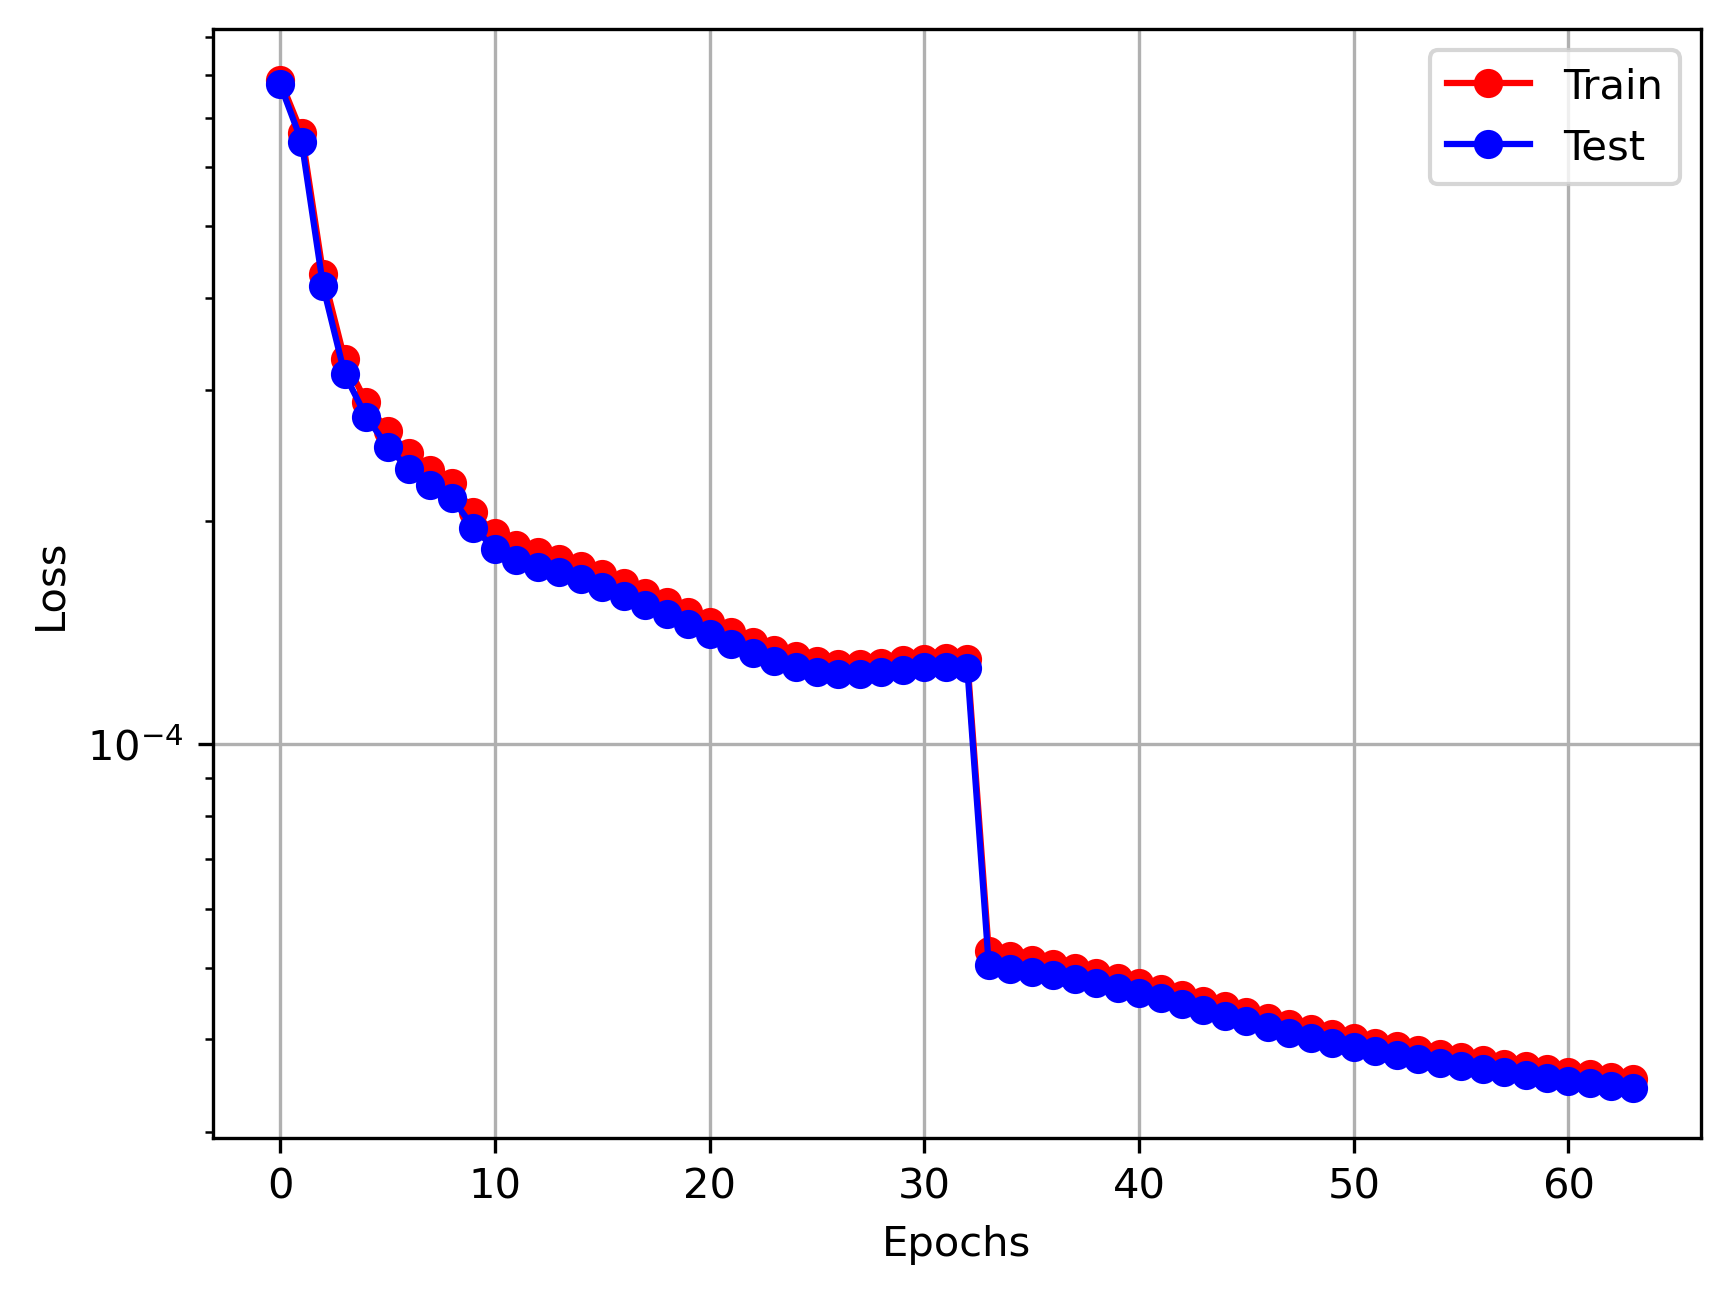

In [142]:
plt.plot(trainer.train_losses, '-o', color="red", label = "Train")
plt.plot(trainer.test_losses, '-o', color="blue", label = "Test")
plt.grid()
plt.yscale('log')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Test it:

In [144]:
n_loops = 10
index = 2
alpha = 0.01

test_input = test_features[index]
test_output = test_labels[index]

print(test_input)
print(test_output)

original = test_input[3]

with torch.no_grad():
    for i in range(n_loops):
        print(f"--- {i} ---")
        #test_input_normalized = scaler.transform(test_input)
        test_input_normalized = test_input
        test_input_tensor = torch.from_numpy(test_input_normalized)
        prediction = model(test_input_tensor).item()
        print(f"Pred: {prediction}")
        diff = prediction - original
        true_diff = prediction - test_output
        print(f"Diff: {diff}")
        print(f"Diff (true): {true_diff}")
        # Update the input (recurrent architecture)
        #test_input[3] = prediction - alpha * diff
        test_input[3] = prediction
        print(test_input)

[0.19768338 0.02525862 0.04959609 0.36834803]
[0.3711165]
--- 0 ---
Pred: 0.3686977028846741
Diff: 0.0003496706485748291
Diff (true): [-0.00241879]
[0.19768338 0.02525862 0.04959609 0.3686977 ]
--- 1 ---
Pred: 0.3686988949775696
Diff: 0.0003508627414703369
Diff (true): [-0.00241759]
[0.19768338 0.02525862 0.04959609 0.3686989 ]
--- 2 ---
Pred: 0.3686988353729248
Diff: 0.0003508031368255615
Diff (true): [-0.00241765]
[0.19768338 0.02525862 0.04959609 0.36869884]
--- 3 ---
Pred: 0.3686988353729248
Diff: 0.0003508031368255615
Diff (true): [-0.00241765]
[0.19768338 0.02525862 0.04959609 0.36869884]
--- 4 ---
Pred: 0.3686988353729248
Diff: 0.0003508031368255615
Diff (true): [-0.00241765]
[0.19768338 0.02525862 0.04959609 0.36869884]
--- 5 ---
Pred: 0.3686988353729248
Diff: 0.0003508031368255615
Diff (true): [-0.00241765]
[0.19768338 0.02525862 0.04959609 0.36869884]
--- 6 ---
Pred: 0.3686988353729248
Diff: 0.0003508031368255615
Diff (true): [-0.00241765]
[0.19768338 0.02525862 0.04959609 0.

# Neural networks and rootfinding with gradient

## Toy problem

In [23]:
def func(a, x):
    return x**3 - a

Get feature data:

In [96]:
a_min = -10
a_max = 10

x_min = -20
x_max = 20

size = 100000

a_vals = a_min + (a_max - a_min) * np.random.random_sample(size=size)
x_vals = x_min + (x_max - x_min) * np.random.random_sample(size=size)

features = np.transpose(np.array([a_vals, x_vals]))
features

array([[  5.09164693,  13.0588819 ],
       [  7.39640196,  11.41696937],
       [  7.64242544,  -8.41634678],
       ...,
       [  8.9670572 , -11.65069275],
       [ -4.34317403, -14.66910896],
       [  2.28791808, -12.90509712]])

In [97]:
features.shape

(100000, 2)

Get labels data:

In [98]:
labels = func(features[:, 0], features[:, 1]).reshape(-1, 1)
labels

array([[ 2221.89689582],
       [ 1480.77347049],
       [ -603.81344994],
       ...,
       [-1590.41626599],
       [-3152.19614419],
       [-2151.52255687]])

Convert to float32

In [99]:
features = features.astype(np.float32)
labels = labels.astype(np.float32)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)

In [111]:
# For normalization, use sklearn's StandardScaler -- give None for no normalization
scaler = StandardScaler()
scaler.fit(X_train)
# Convert to PyTorch Datasets as we defined them
train_dataset = data.HDF5Dataset(X_train, y_train, normalization_function = scaler.transform)  # scaler.fit_transform 
test_dataset  = data.HDF5Dataset(X_test, y_test, normalization_function = scaler.transform)  # scaler.transform
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

Define model

In [130]:
model = Net(nb_of_inputs = 2, nb_of_outputs = 1, h = [50, 50], activation_function=torch.nn.Sigmoid).float()
model

Net(
  (linear1): Linear(in_features=2, out_features=50, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=50, out_features=1, bias=True)
)

Train

In [131]:
trainer = nnc2p.Trainer(model, 1e-1, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [132]:
trainer.train()

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 1.91E+06
Test  loss: 1.91E+06

 Epoch 1 
 --------------
Train loss: 5.52E+05
Test  loss: 5.57E+05

 Epoch 2 
 --------------
Train loss: 1.40E+05
Test  loss: 1.44E+05

 Epoch 3 
 --------------
Train loss: 3.36E+04
Test  loss: 3.49E+04

 Epoch 4 
 --------------
Train loss: 1.59E+04
Test  loss: 1.60E+04

 Epoch 5 
 --------------
Train loss: 1.36E+04
Test  loss: 1.38E+04

 Epoch 6 
 --------------
Train loss: 4.66E+04
Test  loss: 4.68E+04

 Epoch 7 
 --------------
Train loss: 1.05E+04
Test  loss: 1.04E+04

 Epoch 8 
 --------------
Train loss: 2.45E+04
Test  loss: 2.50E+04

 Epoch 9 
 --------------
Train loss: 3.53E+04
Test  loss: 3.42E+04

 Epoch 10 
 --------------
Train loss: 1.03E+04
Test  loss: 1.03E+04

 Epoch 11 
 --------------
Train loss: 1.01E+04
Test  loss: 9.94E+03

 Epoch 12 
 --------------
Train loss: 9.93E+03
Test  loss: 9.83E+03

 Epoch 13 
 --------------
Train loss: 1.03E+04
Test  loss: 1.05

Train loss: 7.90E+00
Test  loss: 8.27E+00

 Epoch 116 
 --------------
Train loss: 7.74E+00
Test  loss: 8.11E+00

 Epoch 117 
 --------------
Train loss: 7.61E+00
Test  loss: 7.99E+00

 Epoch 118 
 --------------
Train loss: 7.49E+00
Test  loss: 7.87E+00

 Epoch 119 
 --------------
Train loss: 7.38E+00
Test  loss: 7.75E+00

 Epoch 120 
 --------------
Train loss: 7.27E+00
Test  loss: 7.63E+00

 Epoch 121 
 --------------
Train loss: 7.16E+00
Test  loss: 7.52E+00

 Epoch 122 
 --------------
Train loss: 7.06E+00
Test  loss: 7.41E+00

 Epoch 123 
 --------------
Train loss: 6.96E+00
Test  loss: 7.30E+00

 Epoch 124 
 --------------
Train loss: 6.85E+00
Test  loss: 7.19E+00

 Epoch 125 
 --------------
Train loss: 6.74E+00
Test  loss: 7.07E+00

 Epoch 126 
 --------------
Train loss: 6.63E+00
Test  loss: 6.95E+00

 Epoch 127 
 --------------
Train loss: 6.51E+00
Test  loss: 6.83E+00

 Epoch 128 
 --------------
Train loss: 6.40E+00
Test  loss: 6.70E+00

 Epoch 129 
 --------------
Train 

KeyboardInterrupt: 

Test:

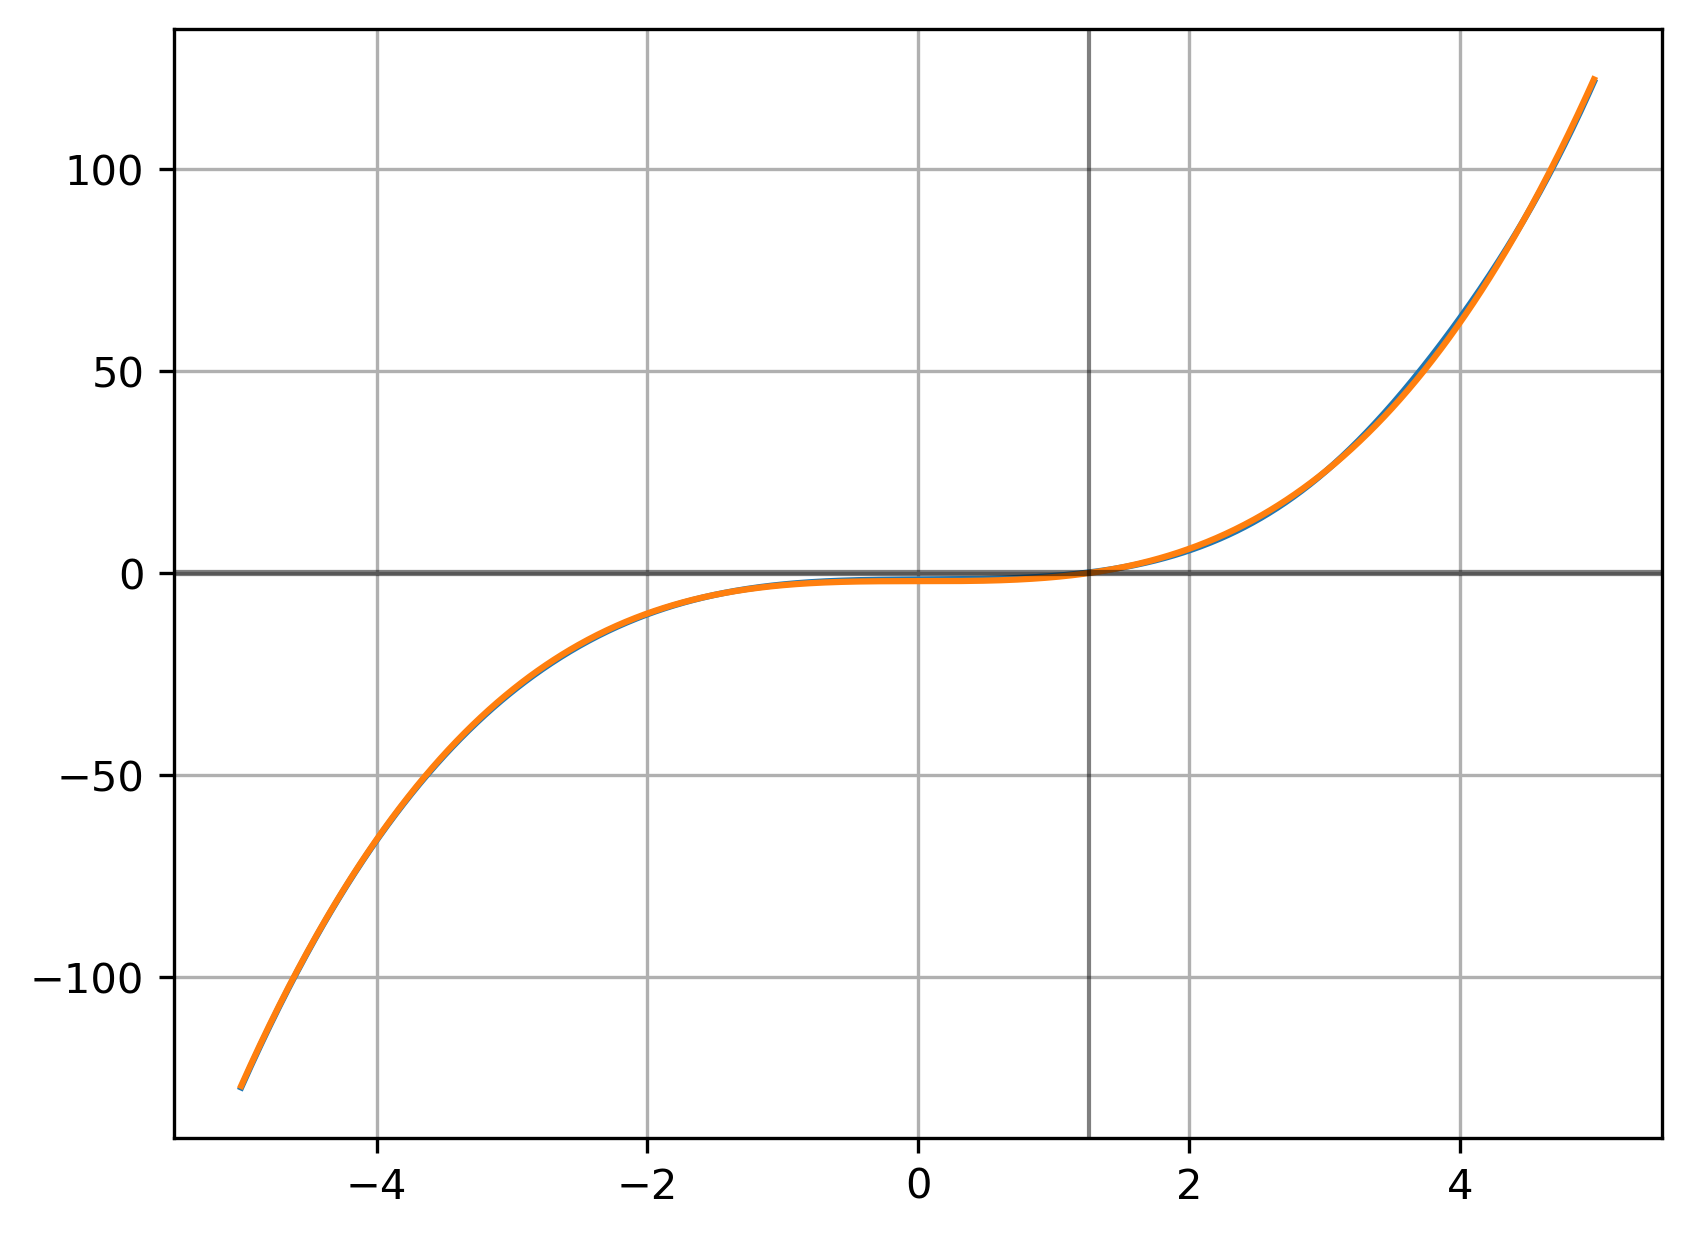

In [141]:
a = 2

x_vals = np.arange(-5, 5, 0.01)
true_vals = func(a, x_vals)

a_vals = np.array([a for _ in range(len(x_vals))])
input_vals = np.transpose(np.array([a_vals, x_vals]))
input_vals = scaler.transform(input_vals)

with torch.no_grad():
    input_vals = torch.from_numpy(input_vals).float()
    y_vals = model(input_vals)
    y_vals = y_vals.numpy()
    
plt.plot(x_vals, y_vals, label = "NN")
plt.plot(x_vals, true_vals, label = "True")
plt.axhline(0, color="black", alpha=0.5)
plt.axvline(a**(1/3), color="black", alpha=0.5, lw=1)
plt.grid()
plt.show()

In [136]:
# torch.save(model, "../Models/toy_problem.pt")

## Testing

In [143]:
features.shape

(100000, 2)

Get the params by hand:

In [147]:
W1 = model.state_dict()["linear1.weight"].detach()
b1 = model.state_dict()["linear1.bias"].detach()
W2 = model.state_dict()["linear2.weight"].detach()
b2 = model.state_dict()["linear2.bias"].detach()
W3 = model.state_dict()["linear3.weight"].detach()
b3 = model.state_dict()["linear3.bias"].detach()

In [159]:
W3.shape

torch.Size([1, 50])

In [154]:
def compute_z(x, W, b):
    return np.matmul(W, x) + b

def compute_activation(x, W, b):
    return sigmoid(compute_z(x, W, b))

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [155]:
test1 = np.array([2, 2, 2])
test2 = np.array([1,2,3])
test1*test2

array([2, 4, 6])

In [228]:
def compute_gradient(x0):
    """x0 is the input for the neural network"""
    with torch.no_grad():
        # Forward pass:
        z1 = compute_z(x0, W1, b1)
        x1 = sigmoid(z1)
        z2 = compute_z(x1, W2, b2)
        x2 = sigmoid(z2)
        z3 = compute_z(x2, W3, b3)
        # Compute backward pass
        # TODO - sign correct or not?
        delta3 = -z3
        delta2 = np.matmul(W3, delta3.T) * sigmoid_prime(z2)
        delta1 = np.matmul(W2, delta2.T) * sigmoid_prime(z1)
        
        return delta1

In [229]:
x0 = np.array([0.2, 4]).reshape(1, -1)
print(x0.shape)
x0 = scaler.transform(x0)
x0 = torch.from_numpy(x0).float()

(1, 2)


Compute gradient

In [230]:
gradient = compute_gradient(x0.T)
gradient

C:\Users\thibe\AppData\Local\Temp\ipykernel_2016\2712056450.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -2.8546e-05,
         -6.8288e+00, -2.1327e+06],
        [-0.0000e+00, -9.6116e+00, -2.9014e+02,  ..., -5.2971e-10,
         -6.0414e-05, -1.8932e+02],
        [-0.0000e+00, -2.2782e+01, -5.6745e+02,  ..., -9.6341e-10,
         -1.3908e-04, -4.5408e+02],
        ...,
        [-0.0000e+00, -0.0000e+00, -1.7986e+02,  ..., -1.5044e-07,
         -1.9035e-02, -6.9563e+04],
        [ 0.0000e+00,  8.6908e+01,  5.8208e+02,  ...,  2.1708e-09,
          2.1287e-04,  1.3933e+03],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -1.4572e-07,
         -1.3379e-02, -7.3015e+04]])

Using PyTorch (preferably not!)

In [231]:
a_vals = np.array([a for _ in range(len(x_vals))])
x_vals = np.arange(-5, 5, 0.01)

In [233]:
def compute_gradient(input_vals):
    preds = model(input_vals)
    grd = torch.zeros ((1, 1)) # same shape as preds
    grd[0, 0] = 1 # column of Jacobian to compute
    preds.backward(gradient = grd, retain_graph = True)
    J[:,0] = input_vals.grad.view(2).float() # fill in one column of Jacobian
    input_vals.grad.zero_() # .backward() accumulates gradients, so reset to zero
    
    return J

Initialize jacobian:

In [268]:
J = torch.zeros((2, 1)) # loop will fill in Jacobian
J = J.float()

Get input as tensor

In [269]:
input_vals = np.transpose(np.array([0.2, 4]))
input_vals = scaler.transform(input_vals.reshape(1, -1))
input_vals = torch.from_numpy(input_vals).float()

In [270]:
input_vals

tensor([[0.0395, 0.3507]])

Finally, compute gradient

In [271]:
input_vals.requires_grad_()
J = compute_gradient(input_vals)
print(J)

tensor([[ -4.4239],
        [538.0892]])


In [272]:
J[1]

tensor([538.0892])

In [273]:
input_vals = input_vals.detach()
input_vals[0,1] = input_vals[0,1] - 0.01 * J[1]
input_vals

tensor([[ 0.0395, -5.0302]])

__Loop:__

In [287]:
n_loops = 100
alph = 0.0001
input_vals = np.transpose(np.array([0.2, 4]))
input_vals = scaler.transform(input_vals.reshape(1, -1))
input_vals = torch.from_numpy(input_vals).float()

for i in range(n_loops):
    preds = model(input_vals)
#     print(preds)
    # Initialize Jacobian
    J = torch.zeros((2, 1))
    J = J.float()
    # Require grad, compute grad
    input_vals.requires_grad_()
    J = compute_gradient(input_vals)
    grad = J[1]
    print(grad)
    if grad > 0:
        sign = + 1
    else:
        sign = -1
    # Disable grad, update params
    input_vals = input_vals.detach()
    input_vals[0,1] = input_vals[0,1] - sign * alph * grad

tensor([538.0892])
tensor([412.5381])
tensor([303.4356])
tensor([227.1191])
tensor([177.6713])
tensor([144.2197])
tensor([120.3295])
tensor([102.5062])
tensor([88.7305])
tensor([77.8156])
tensor([68.9595])
tensor([61.6702])
tensor([55.5640])
tensor([50.4009])
tensor([45.9799])
tensor([42.1520])
tensor([38.8241])
tensor([35.9136])
tensor([33.3299])
tensor([31.0476])
tensor([29.0091])
tensor([27.1809])
tensor([25.5225])
tensor([24.0342])
tensor([22.6840])
tensor([21.4528])
tensor([20.3302])
tensor([19.3008])
tensor([18.3549])
tensor([17.4845])
tensor([16.6812])
tensor([15.9374])
tensor([15.2493])
tensor([14.6086])
tensor([14.0145])
tensor([13.4593])
tensor([12.9401])
tensor([12.4567])
tensor([12.0039])
tensor([11.5779])
tensor([11.1793])
tensor([10.8026])
tensor([10.4505])
tensor([10.1172])
tensor([9.8033])
tensor([9.5077])
tensor([9.2264])
tensor([8.9609])
tensor([8.7100])
tensor([8.4714])
tensor([8.2464])
tensor([8.0315])
tensor([7.8274])
tensor([7.6348])
tensor([7.4510])
tensor([7.276